# Compare Psytrack Regressors to Model with Additional Prev Violation 

**Goal**: Given the new dataset thresholded to only trained data, assess if a previous violation improves the model. 

Given previous results on the truncated violtionation dataset, I hypothesize that model fit be better when prev violation history is included.

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

from multiglm.experiments.experiment import load_experiment
from multiglm.experiments.experiment_compare_models import ExperimentCompareModels
from multiglm.models.multiclass_logistic_regression import MultiClassLogisticRegression
from multiglm.visualizations.model_visualizer import ModelVisualizerCompare
from multiglm.features.design_matrix_generator import DesignMatrixGeneratorFilteredHistory
from multiglm.data import ANIMAL_IDS

sns.set_context("talk")
%load_ext autoreload
%autoreload 2


In [4]:
model_config = {
    "psytrack_features": {  # MODEL 1
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "design_matrix_generator": DesignMatrixGeneratorFilteredHistory,
        "filter_implementation": {"prev_violation": -1},  # no filter & drop column
    },
    "prev_violation": {  # MODEL 2
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "design_matrix_generator": DesignMatrixGeneratorFilteredHistory,
        "filter_implementation": {"prev_violation": 0},  # no filter
    },
}


params = {
    "animals": ANIMAL_IDS,
    "data_type": "new_trained",
    "sigmas": [0.07, 0.13, 0.25, 0.5, 1, 2, 4, 8, 16],
    "random_state": 47,
    "null_mode": "multi",
    "eval_train": True,
    "tau_columns": ["prev_violation"],
    "model_config": model_config,
    "min_training_stage": 4,
}

save_name = "2024_02_16_compare_prev_violation.pkl"
ORDER = ["psytrack_features", "prev_violation"]

In [3]:
experiment = ExperimentCompareModels(params)
experiment.run()
experiment.save(save_name)

Loading dataset type : new_trained
Loading data for animal ids:  ['W051', 'W060', 'W065', 'W066', 'W068', 'W072', 'W073', 'W074', 'W075', 'W078', 'W080', 'W081', 'W082', 'W083', 'W088', 'W089', 'W094']
minimum training stage is  4

 >>>> evaluating animal W051 <<<<

 ***** evaluating model psytrack_features w/ sigma 0.07 *****
         Current function value: 64995.381417
         Iterations: 24
         Function evaluations: 103
         Gradient evaluations: 91

 ***** evaluating model psytrack_features w/ sigma 0.13 *****
Optimization terminated successfully.
         Current function value: 64759.621627
         Iterations: 25
         Function evaluations: 38
         Gradient evaluations: 38

 ***** evaluating model psytrack_features w/ sigma 0.25 *****
         Current function value: 64687.335386
         Iterations: 24
         Function evaluations: 103
         Gradient evaluations: 90

 ***** evaluating model psytrack_features w/ sigma 0.5 *****
         Current function val

In [5]:
experiment = load_experiment(save_name, compressed=False)
mvc = ModelVisualizerCompare(experiment)

In [ ]:

df = mvc.find_best_fit(group="model_name")
for model_name, model_df in df.groupby("model_name"):
    mvc.plot_sigma_summary(model_df, title=f"{model_name} fit sigma summary")

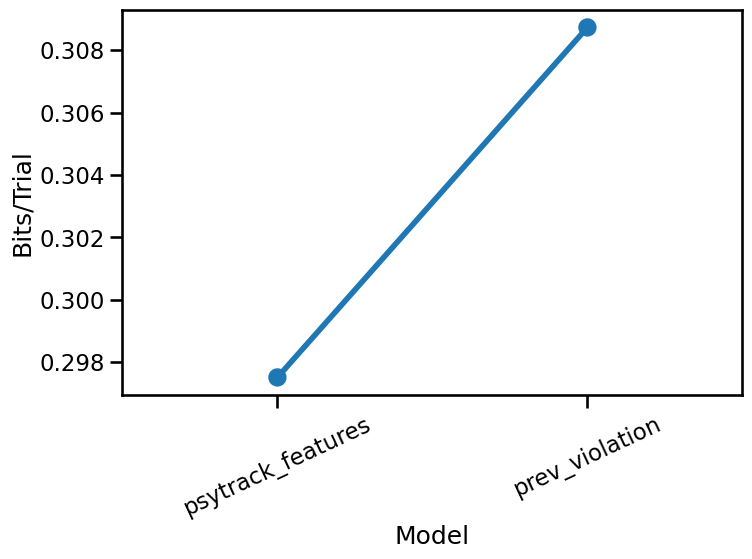

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
mvc.plot_model_comparison(
    hue=None,
    ax=ax,
    order=["psytrack_features", "prev_violation"],
    errorbar=None,
)

(0.15, 0.35)

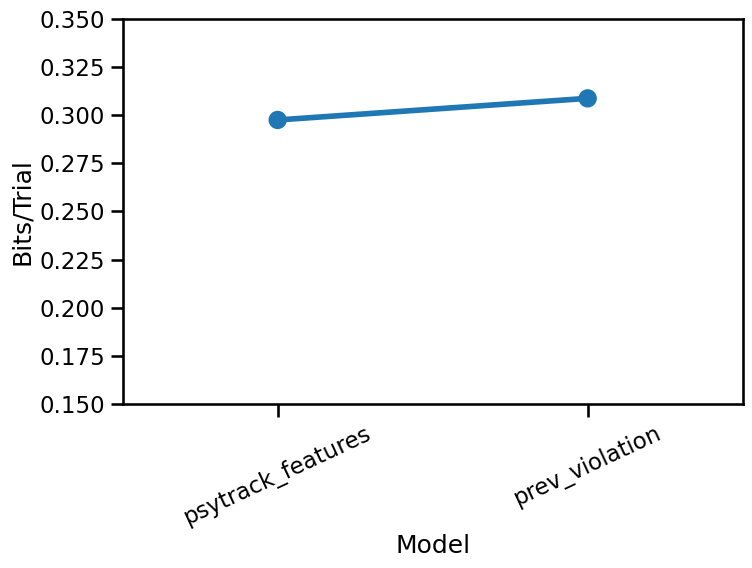

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
mvc.plot_model_comparison(
    hue=None,
    ax=ax,
    order=["psytrack_features", "prev_violation"],
    errorbar=None,
)

ax.set_ylim(0.15, 0.35)

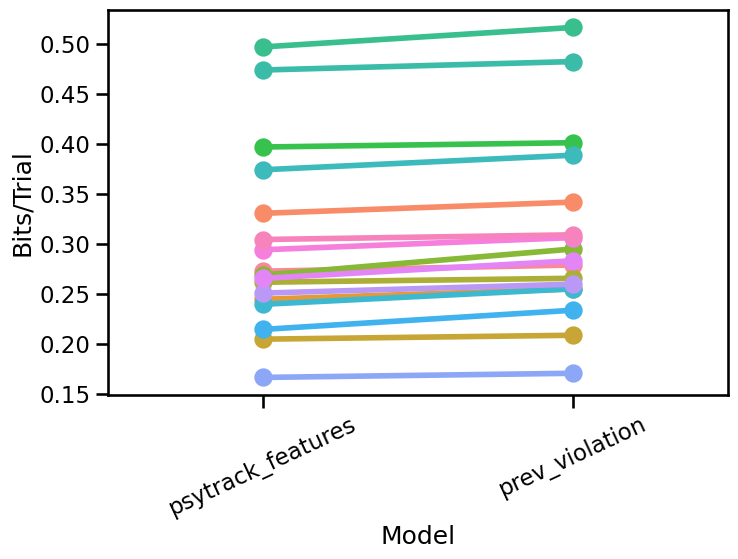

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
mvc.plot_model_comparison(
    hue="animal_id",
    ax=ax,
    order=["psytrack_features", "prev_violation"],
)

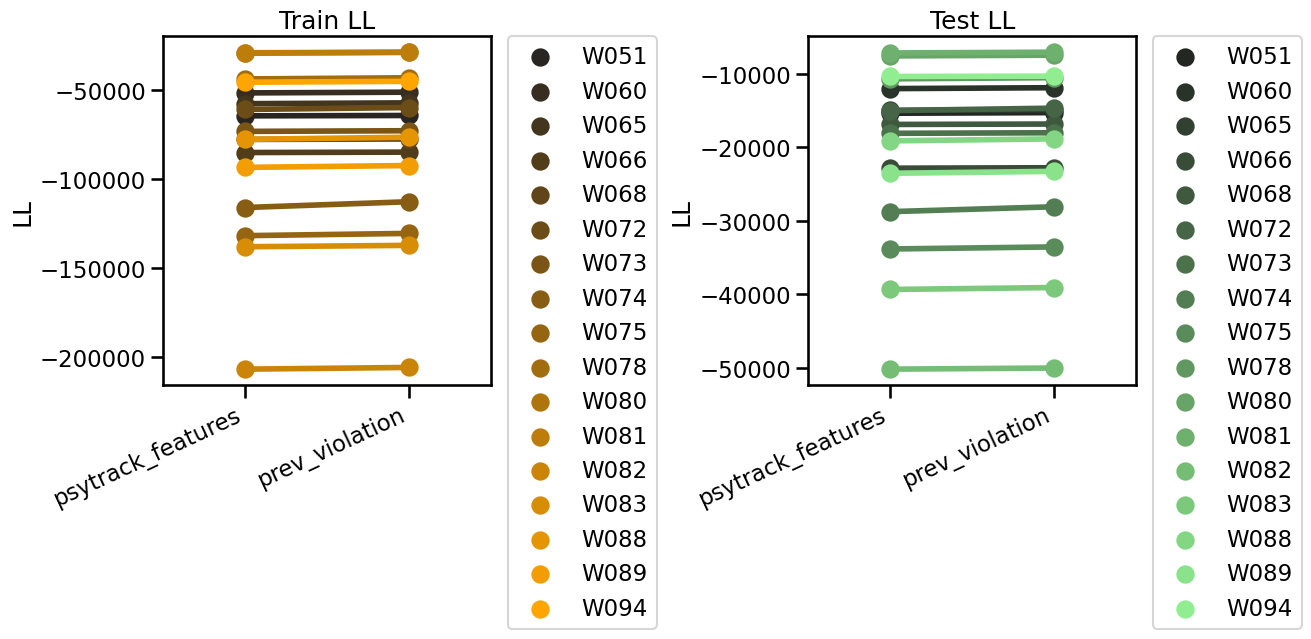

In [7]:
mvc.plot_train_and_test_ll(
    order=["psytrack_features", "prev_violation"],
    hue="animal_id",
)

<Axes: title={'center': 'Model Improvement- mu: 185.02 std: 153.69 \n psytrack_features -> prev_violation'}, xlabel='animal_id', ylabel='Delta test LL (new - base)'>

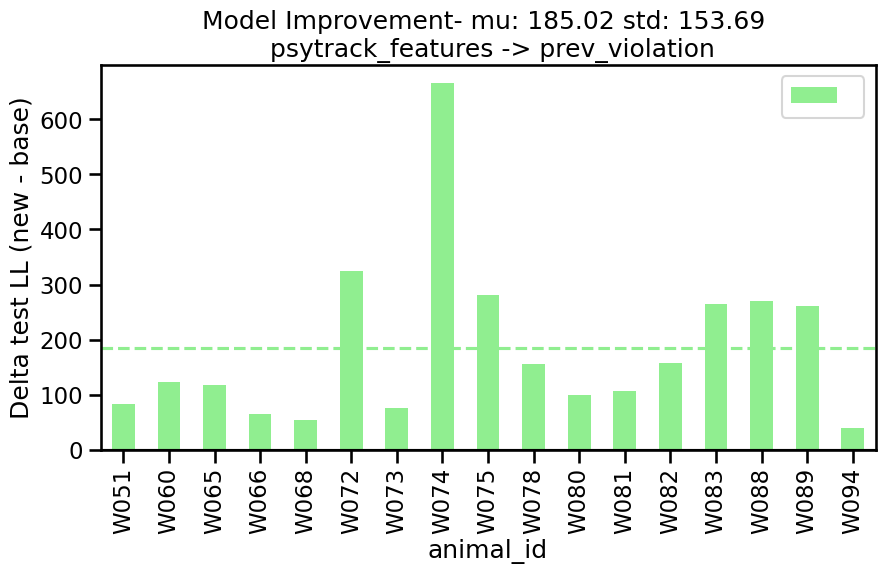

In [9]:
mvc.plot_ll_delta_by_animal(
    base_model_name="psytrack_features",
    new_model_name="prev_violation",
    type="test",
)

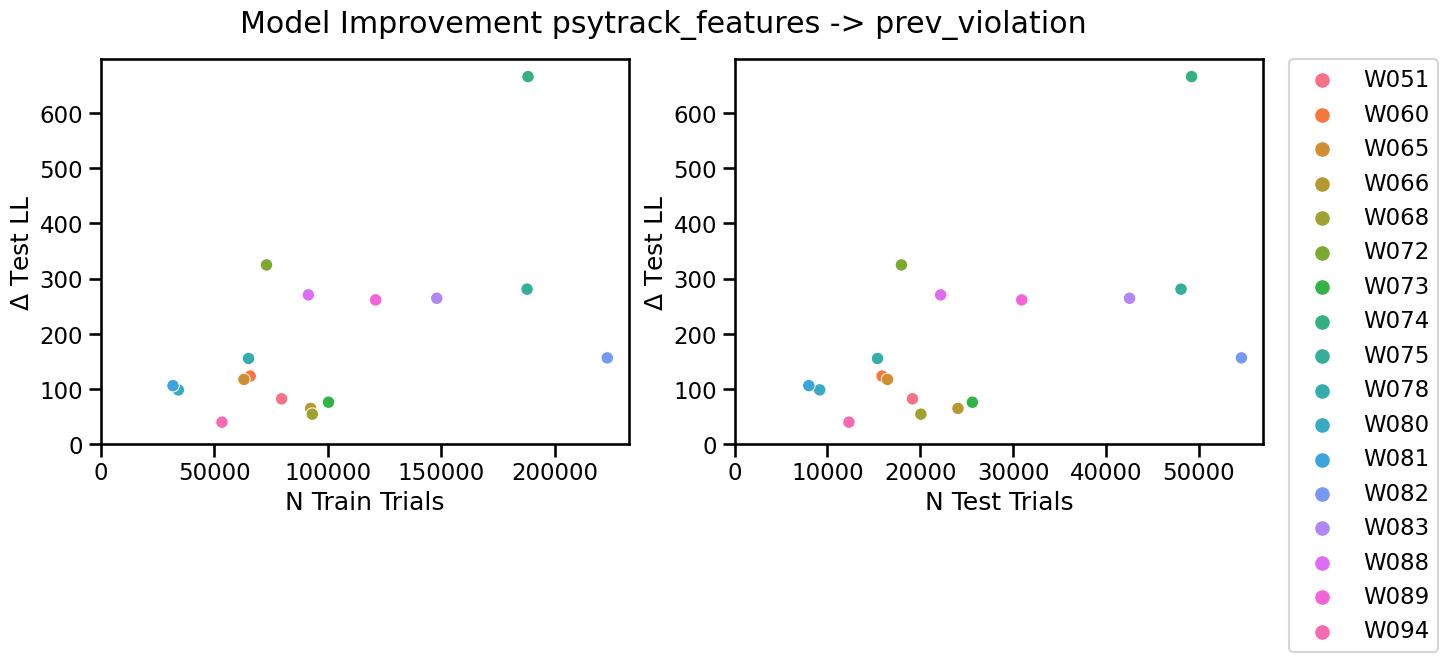

In [9]:
for i in range(len(ORDER)):
    for j in range(i + 1, len(ORDER)):
        mvc.plot_delta_ll_by_train_test_size(ORDER[i], ORDER[j])

In [47]:
from multiglm.data.dataset_loader import DatasetLoader

loader = DatasetLoader(animal_ids=ANIMAL_IDS, data_type=params["data_type"])
df = loader.load_data()

Loading data for animal ids:  ['W051', 'W060', 'W065', 'W066', 'W068', 'W072', 'W073', 'W074', 'W075', 'W078', 'W080', 'W081', 'W082', 'W083', 'W088', 'W089', 'W094']


In [15]:
import pandas as pd

session_avg_hit_viol = pd.read_csv(
    "/Users/jessbreda/Desktop/github/animal-learning/data/processed/from_eda/01_trained_session_avg_hit_viol_rates.csv"
)

In [19]:
qq = pd.merge(
    session_avg_hit_viol,
    mvc.compute_delta_ll_pivot(ORDER[0], ORDER[1], value="nll"),
    on="animal_id",
)

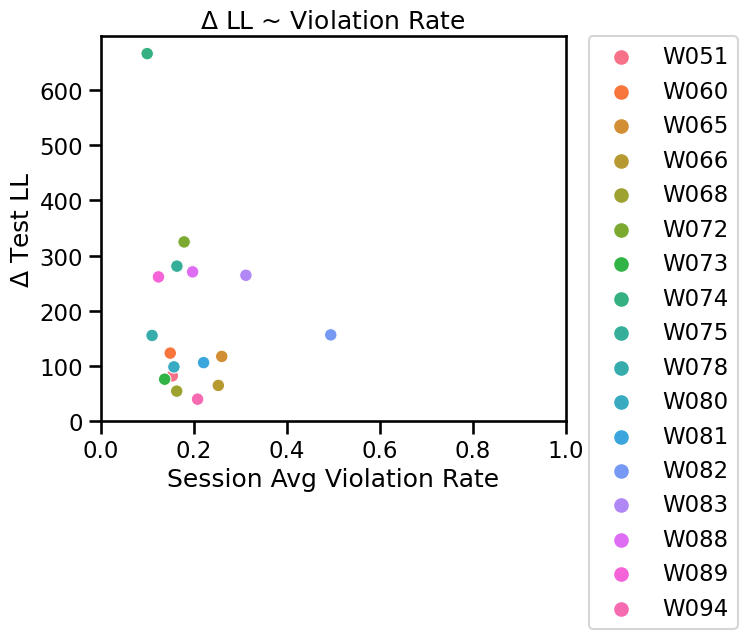

In [22]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.scatterplot(data=qq, x="trained_violation", y="delta_ll", hue="animal_id", ax=ax)

_ = ax.set(
    title="$\Delta$ LL ~ Violation Rate",
    xlabel="Session Avg Violation Rate",
    ylabel="$\Delta$ Test LL",
    ylim=(0, None),
    xlim=(0, 1),
)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

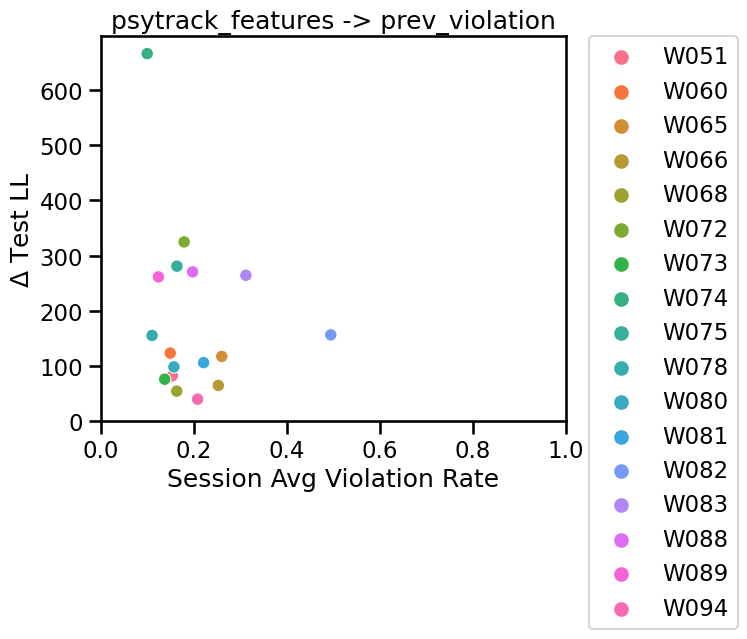

In [26]:
mvc.plot_delta_ll_by_violation_rate(ORDER[0], ORDER[1])

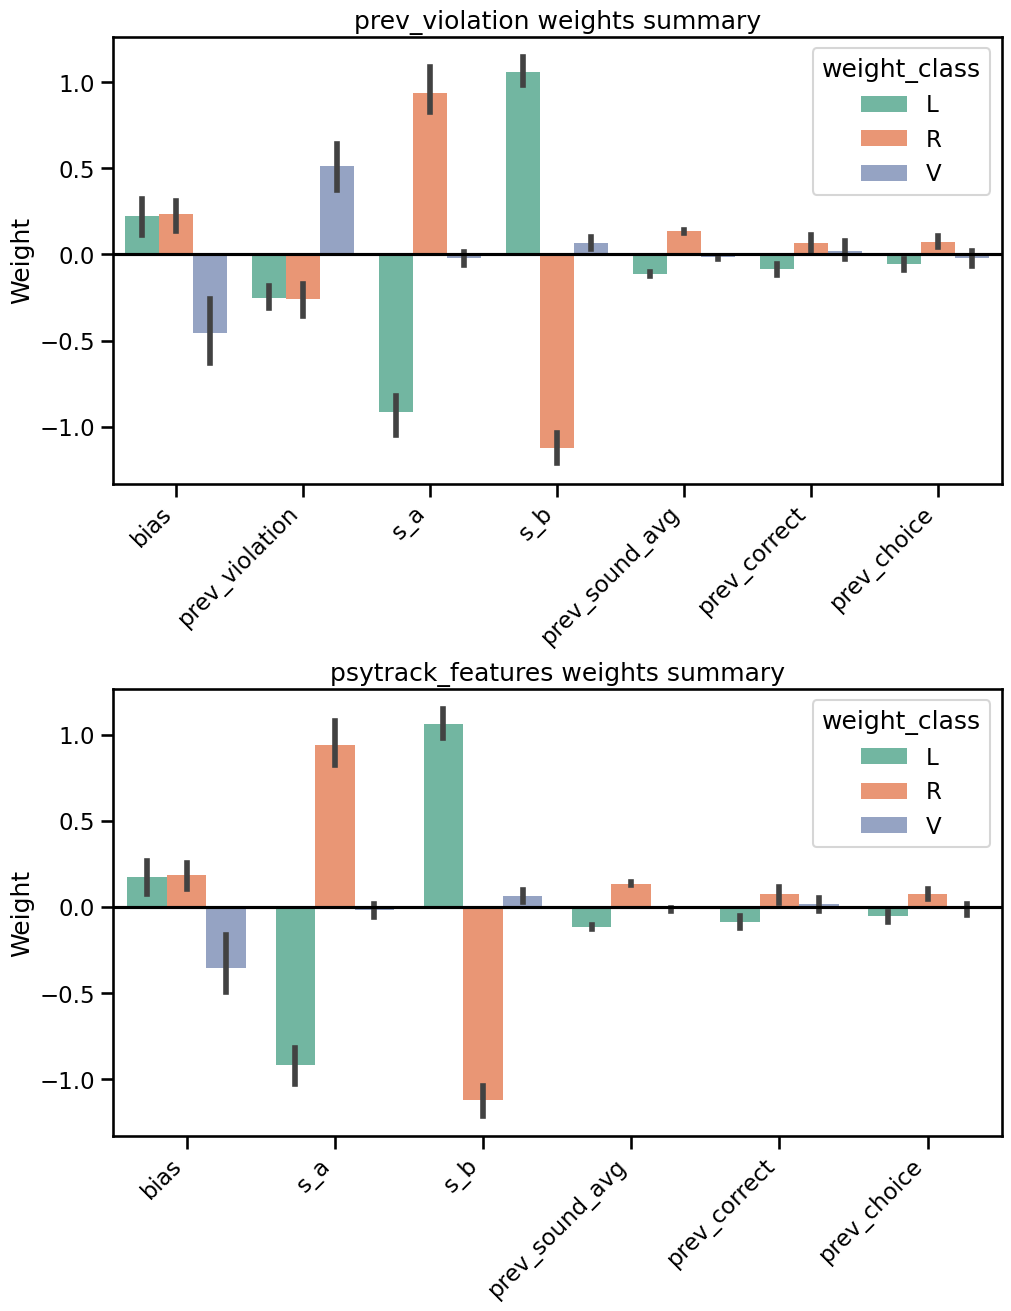

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(10, 13), constrained_layout=True, sharey=True)

best_fit_by_model = mvc.find_best_fit(group=["animal_id", "model_name"])

for ii, (model_name, model_df) in enumerate(best_fit_by_model.groupby("model_name")):
    unpacked = mvc.unpack_features_and_weights(model_df)

    mvc.plot_weights_summary(
        df=unpacked,
        ax=ax[ii],
        palette="Set2",
        title=f"{model_name} weights summary",
    )